# UNet Image Segmentation Training with CamVid

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch, torchvision, wandb, cv2
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchsummary import summary
from unet import *
from camvid import *

/home/hexagon/miniconda3/envs/torch39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(720, 960, 3)


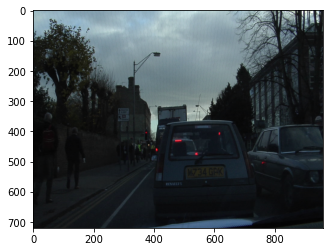

In [2]:
# loading CamVid
df = pd.read_csv("CamVid/class_dict.csv")
label_dict = dict()
for x,rows in enumerate(df.iterrows()):
    rgb = [rows[1]['r'],rows[1]['g'],rows[1]['b']]
    label_dict[x] = rgb

img = cv2.imread("CamVid/train/0001TP_009240.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)

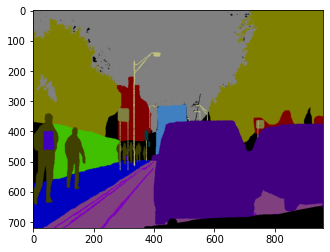

In [3]:
mask = cv2.imread("CamVid/train_labels/0001TP_009240_L.png")
mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
plt.imshow(mask)

In [4]:
SHAPE = (720//8*7, 960//8*7)
batch_size = 1

IMAGE_PATH = "CamVid/train/*.png"
MASK_PATH = "CamVid/train_labels/*.png"

VAL_PATH = "CamVid/val/*.png"
VAL_MASK = "CamVid/val_labels/*.png"

train_dataset = CamVidDataset(SHAPE, IMAGE_PATH, MASK_PATH, label_dict)
# print(train_dataset[0])
# train_dataset = Subset(train_dataset, np.arange(0, num_train))
trainloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)

val_dataset = CamVidDataset(SHAPE, VAL_PATH, VAL_MASK, label_dict)
print(len(val_dataset))
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

100


In [5]:
# config
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using dev {device}")
model = UNet(in_channels=3, out_channels=32).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
summary(model, (3, *SHAPE))

using dev cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 630, 840]           1,728
       BatchNorm2d-2         [-1, 64, 630, 840]             128
              ReLU-3         [-1, 64, 630, 840]               0
            Conv2d-4         [-1, 64, 630, 840]          36,864
       BatchNorm2d-5         [-1, 64, 630, 840]             128
              ReLU-6         [-1, 64, 630, 840]               0
      DoubleConv2d-7         [-1, 64, 630, 840]               0
         MaxPool2d-8         [-1, 64, 315, 420]               0
            Conv2d-9        [-1, 128, 315, 420]          73,728
      BatchNorm2d-10        [-1, 128, 315, 420]             256
             ReLU-11        [-1, 128, 315, 420]               0
           Conv2d-12        [-1, 128, 315, 420]         147,456
      BatchNorm2d-13        [-1, 128, 315, 420]             256
             ReLU-14  

In [6]:
# init wandb
wandb.init(project="deepdriving-image-segmentation")
config = wandb.config

# hyperparamters
config.batch_size = batch_size
config.epochs = 30
config.architecture = "vanilla unet"
config.activation = "none"
config.input_size = SHAPE

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: h3x4g0n. Use `wandb login --relogin` to force relogin


In [ ]:
def adjust_mask(self, mask, label_dict):
    segmentation_map_list = []
    for x,color in enumerate(label_dict.values()):
        segmentation_map = (mask==color).all(axis=-1)
        segmentation_map=(segmentation_map*1)
        segmentation_map*=x
        segmentation_map_list.append(segmentation_map)
        
    return np.amax(np.stack(segmentation_map_list,axis=-1),axis=-1)

def convert_n_channels_2_rgb(image):
    image = np.amax(image,axis=-1)
    image = (image).astype(np.uint8)
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    
    for l in label_dict.keys():
        idx = image == l
        r[idx] = label_dict[l][0]
        g[idx] = label_dict[l][1]
        b[idx] = label_dict[l][2]
    return np.stack([r,g,b],axis=-1)

# set up inference
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(SHAPE),
            transforms.ToTensor()
        ])

In [ ]:
# training + logging loop
wandb.watch(model, log="all")

for epoch in range(config.epochs): 
    with tqdm(trainloader, unit="batch") as tepoch:

        running_loss = 0.0
        for data, target in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            
            data, target = data.to(device), target.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(data).to(device)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            # calculating accuracy
            # predictions = outputs.argmax(dim=1, keepdim=True)
            # correct = (predictions == target).sum().item()
            # accuracy = correct / batch_size

            # print statistics
            tepoch.set_postfix(loss=loss.item())

        # run inference
        img = cv2.imread("CamVid/train/0001TP_009240.png")
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        inference = transform(img)
        run_inference = model(inference[None,:].to(device)).cpu().detach().numpy()
        result = np.moveaxis(run_inference[0], 0, -1)
        plt.imshow(convert_n_channels_2_rgb(result))

        # log
        wandb.log({
            "epoch": epoch,
            "test_loss": loss.item(),
            "test_inference": wandb.Image(convert_n_channels_2_rgb(result))
        })

wandb.finish()
print('Finished Training')

In [ ]:
# saving
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)

In [ ]:
# testing
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

# print images
plt.figure(figsize=(20,20))
plt.imshow(torchvision.utils.make_grid(images.cpu()).permute(1, 2, 0))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))